In [1]:
!pip install -q tensorflow-recommenders

In [2]:
import os
import pprint
import tempfile
from pathlib import Path
from typing import Dict, Text
import pandas as pd
import numpy as np
import torch 
import random
import time
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import gc

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)

In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(0)

In [4]:
data_path = Path("/kaggle/input/vds-news-recommendation")
train = pd.read_parquet(data_path/"train.parquet")
user_profile = pd.read_parquet(data_path/"user_profile.parquet")
article_info = pd.read_parquet(data_path/"article_information.parquet")
# public_test = pd.read_parquet(data_path/"public_test.parquet")
private_test = pd.read_parquet(data_path/"private_test.parquet")

In [5]:
# test = train[train['event_time'].dt.strftime('%Y-%m-%d') == '2022-04-11']
# train = train.drop(test.index)

test = private_test
test['label'] = -1

In [6]:
print(user_profile.shape)
user_profile.head()

(89762, 4)


,user_id,gender,age,os_name
0,28501fb31cb1999658ce374fccca6812,Male,45-54,windows
1,2366fe0ce31b1f9e0fd38243afe45d90,Female,55-64,windows
2,7a113f19617277f1e7f9348d29123dd7,Male,<18,windows
3,51dad112607b09338ceb9585a9d5f42b,Female,55-64,windows
4,3944c237ce91544babbbafccd127a1eb,Male,55-64,windows


In [7]:
print(article_info.shape)
print(f" time range: from {article_info['published_time'].min().__str__()} to"
      f" {article_info['published_time'].max().__str__()}")
article_info.head()

(84066, 5)
 time range: from 2022-04-03 00:00:00 to 2022-04-13 23:59:13


,article_id,published_time,title,domain,category
0,8c4c166c92421fbccee4c9275dad11b7,2022-04-13 10:47:19,"Kỳ Duyên chuẩn “chị đại” khi làm giám khảo, ph...",m.vietgiaitri.com,Giải trí
1,53bc3a9b769782b8ab11b3871e222be0,2022-04-05 15:41:53,Thêm ảnh Lệ Quyên và Hà Hồ “mỗi người mỗi việc...,vietgiaitri.com,None
2,c178534931e45d00ec4044e897bdb8cf,2022-04-12 09:04:00,Cam Lâm (Khánh Hòa) cảnh báo: Phân lô bán nền ...,doanhnghiepvn.vn,Bất động sản
3,76f98c648d161d26c240cd35c315450d,2022-04-07 15:33:00,KHÔNG THỂ TIN NỔI: Poster MV mới của Thiều Bảo...,tiin.vn,Giải trí
4,aeb84e04405bb60fc8fd8caa40d0b875,2022-04-10 04:14:48,Bán vé xem trận giao hữu giữa đội tuyển U23 Vi...,m.tuoitre.vn,Thể thao


In [8]:
article_info['category'].unique()

array(['Giải trí', None, 'Bất động sản', 'Thể thao', 'Xe', 'Tin thế giới',
       'Pháp luật', 'Giáo dục', 'Đời sống', 'Xã hội', 'Kinh tế',
       'Công nghệ', 'Văn hóa', 'Game', 'Khoa học'], dtype=object)

In [9]:
train = train.merge(user_profile, on='user_id', how='left')
train = train.merge(article_info, on='article_id', how='left')

test = test.merge(user_profile, on='user_id', how='left')
test = test.merge(article_info, on='article_id', how='left')

In [10]:
train.head()

,user_id,article_id,event_time,label,gender,age,os_name,published_time,title,domain,category
0,6e4b2ae012590b002f0552a195d03592,f38294602078b144a54267928e2daa1b,2022-04-06 10:56:51,0,Male,55-64,windows,2022-04-05 10:12:00,Về miền di tích cuối dãy Trường Sơn (Bình Phước),tintuc.vn,Văn hóa
1,49937761681b52eb2a17fe87133b7f54,d3db6da84a6e4520122aa72839f83d70,2022-04-07 16:57:09,0,Male,55-64,windows,2022-04-06 06:35:29,Lấy cảm hứng từ gấu Bắc Cực để tạo ra chiếc lề...,m.infonet.vietnamnet.vn,Khoa học
2,86e9d75001cfbe4a94a15a45715a4a90,a53dd8f8d842f275caccd9ce99bde14e,2022-04-11 20:37:58,0,Male,35-44,windows,2022-04-10 16:10:53,Ếch thoát chết thần kỳ dù bị rắn cắn chân,vietbao.vn,Khoa học
3,68794b2e9c86a8d21fec24182d476147,6ee66eab1744f56b39e42691e88383e5,2022-04-06 20:48:33,0,Female,25-34,windows,2022-04-06 10:38:03,"'Chán' làm điên đảo thị trường tiền số, Elon M...",cafef.vn,Công nghệ
4,44302cee26c3ba35b3c2d3835d73acf3,9723c867ddf55424175c0eb9d5487d52,2022-04-08 16:06:52,0,Male,55-64,windows,2022-04-08 10:00:00,"Mẹ vịt liều lĩnh ""đột nhập"" khoa sản và hạ sin...",yan.vn,Đời sống


In [11]:
# impute category
def infer_category(df):
    article_null_filled = pd.read_json('/kaggle/input/vds-news-embeddings/category.json', orient ='index').reset_index()
    article_null_filled.columns=['article_id', 'category_infer']
    cate_infer = dict(zip(article_null_filled['article_id'].values, article_null_filled['category_infer'].values))
    df['category_infer'] = df['category']
    infer_indices = df[df['category_infer'].isna()].index.values
    df.loc[infer_indices, 'category_infer'] = df.loc[infer_indices, 'article_id'].map(lambda s : cate_infer[s])
    return df['category_infer'].values

train['category_infer'] = infer_category(train[['article_id', 'category']])
test['category_infer'] = infer_category(test[['article_id', 'category']])

train = train.drop(columns=['category'])
test = test.drop(columns=['category'])

In [12]:
# transform domain
train['domain'] = train['domain'].map(lambda x: x[2:] if x[:2] == 'm.' else x)
test['domain'] = test['domain'].map(lambda x: x[2:] if x[:2] == 'm.' else x)

# Create user features

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
def create_user_features(df):
    user_features = df.groupby('user_id').agg({
        'user_id': 'count'
    })
    user_features.columns = ['user_impressions']
    user_features = user_features.reset_index()
    user_features['user_impressions_norm'] = scaler.fit_transform(np.array(user_features['user_impressions']).reshape(-1, 1))
    return user_features

In [15]:
user_features = create_user_features(pd.concat([train, test]))
train = train.merge(user_features, on=['user_id'], how='left')
test = test.merge(user_features, on=['user_id'], how='left')

del user_features
gc.collect()

0

# Create item features

In [16]:
def create_item_features(df):
    item_features = df.groupby('article_id').agg({
        'article_id': 'count'
    })
    item_features.columns = ['item_impressions']
    item_features = item_features.reset_index()
    item_features['item_impressions_norm'] = scaler.fit_transform(np.array(item_features['item_impressions']).reshape(-1, 1))
    return item_features

In [17]:
item_features = create_item_features(pd.concat([train, test]))
train = train.merge(item_features, on=['article_id'], how='left')
test = test.merge(item_features, on=['article_id'], how='left')

del item_features
gc.collect()

0

In [18]:
EMBEDDING_DIM = 512
item_title_embeddings = np.load('/kaggle/input/vds-news-embeddings/item_embeddings_512dims.npy')
unique_article_ids = article_info['article_id'].values
embedding_matrix = np.zeros((len(item_title_embeddings) + 1, EMBEDDING_DIM))
embedding_matrix[1:] = item_title_embeddings

# Create interaction features

In [19]:
def create_user_item_features(df):
    df['timestamp'] = (df['event_time'] - df['published_time']).dt.total_seconds()
    df['event_date'] = df['event_time'].dt.strftime('%Y-%m-%d')
    df['period'] = pd.cut(df['event_time'].dt.hour,
                         bins=[0, 6, 12, 18, 24],
                         labels=['night', 'morning', 'afternoon', 'evening'],
                         right=False,
                         include_lowest=True)
    df['period'] = df['period'].astype(str)
    return df
train = create_user_item_features(train)
test = create_user_item_features(test)

In [20]:
item_date_impress = pd.concat([train, test]).groupby(['article_id', 'event_date']).size().to_frame('item_date_impress').reset_index()
item_date_impress['item_date_impress'] = scaler.fit_transform(np.array(item_date_impress['item_date_impress']).reshape(-1, 1)) # norm

train = train.merge(item_date_impress, on=['article_id', 'event_date'], how='left')
test = test.merge(item_date_impress, on=['article_id', 'event_date'], how='left')

del item_date_impress
gc.collect()

80

In [21]:
item_period_impress = pd.concat([train, test]).groupby(['article_id', 'event_date', 'period']).size().to_frame('item_period_impress').reset_index()
item_period_impress['item_period_impress'] = scaler.fit_transform(np.array(item_period_impress['item_period_impress']).reshape(-1, 1))

train = train.merge(item_period_impress, on=['article_id', 'event_date', 'period'], how='left')
test = test.merge(item_period_impress, on=['article_id', 'event_date', 'period'], how='left')

del item_period_impress
gc.collect()

0

In [22]:
tmp = pd.concat([train, test]).sort_values(['article_id', 'event_time']).drop_duplicates(subset=['article_id'], keep='last')
tmp['item_per_hour_impress'] = tmp['item_impressions'] / (tmp['timestamp'] / 60 / 60)
tmp['item_per_hour_impress'] = scaler.fit_transform(np.array(tmp['item_per_hour_impress']).reshape(-1, 1))

train = train.merge(tmp[['article_id', 'item_per_hour_impress']], on=['article_id'], how='left')
test = test.merge(tmp[['article_id', 'item_per_hour_impress']], on=['article_id'], how='left')

In [23]:
# create user reads category ratio col
train = train.sort_values(['user_id', 'event_time'])

train['label_shift'] = train.groupby(['user_id', 'category_infer'])['label'].shift(fill_value=0)
train['cate_impress_count'] = train.groupby(['user_id', 'category_infer'])['label'].cumcount() + 1
train['cate_read'] = train.groupby(['user_id', 'category_infer'])['label_shift'].cumsum().astype('float')
train['user_cate_read_ratio'] = train['cate_read'] / train['cate_impress_count']
train = train.drop(columns=['label_shift', 'cate_impress_count', 'cate_read'])

tmp = train.groupby(['user_id', 'category_infer'])['label'].mean().to_frame('user_cate_read_ratio').reset_index()
test = test.merge(tmp, on=['user_id', 'category_infer'], how='left').fillna(0)

In [24]:
user_cate_impress = pd.concat([train, test]).groupby(['user_id', 'category_infer']).size().to_frame('user_cate_impress').reset_index()
user_cate_impress['user_cate_impress_norm'] = scaler.fit_transform(np.array(user_cate_impress['user_cate_impress']).reshape(-1, 1))
train = train.merge(user_cate_impress, on=['user_id', 'category_infer'], how='left')
test = test.merge(user_cate_impress, on=['user_id', 'category_infer'], how='left')

train['user_cate_impress_ratio'] = train['user_cate_impress'] / train['user_impressions']
test['user_cate_impress_ratio'] = test['user_cate_impress'] / test['user_impressions']

del user_cate_impress
gc.collect()

35

In [25]:
test.columns

Index(['user_id', 'article_id', 'event_time', 'label', 'gender', 'age',
       'os_name', 'published_time', 'title', 'domain', 'category_infer',
       'user_impressions', 'user_impressions_norm', 'item_impressions',
       'item_impressions_norm', 'timestamp', 'event_date', 'period',
       'item_date_impress', 'item_period_impress', 'item_per_hour_impress',
       'user_cate_read_ratio', 'user_cate_impress', 'user_cate_impress_norm',
       'user_cate_impress_ratio'],
      dtype='object')

In [26]:
df = pd.concat([
    train[['user_id', 'article_id', 'domain', 'category_infer', 'period']], 
    test[['user_id', 'article_id', 'domain', 'category_infer', 'period']],
])
unique_user_ids = df['user_id'].unique()
unique_item_ids = df['article_id'].unique()
unique_domains = df['domain'].unique()
unique_categories = df['category_infer'].unique()
unique_periods = df['period'].unique()

len(unique_user_ids), len(unique_item_ids), len(unique_domains), len(unique_categories), len(unique_periods)

(89749, 75170, 150, 14, 4)

# Create tf Dataset

In [27]:
%%time
def create_custom_ds(df, ds_type='train'):
    use_cols = ['user_id', 'user_cate_read_ratio', 'period', 'user_impressions_norm',
                'article_id', 'domain', 'category_infer', 'item_period_impress', 'item_date_impress',
                'timestamp', 'item_per_hour_impress',
                'user_cate_impress_norm', 'user_cate_impress_ratio', 
                'label']
    if ds_type == 'test':
        use_cols = use_cols[:-1]
    ds = tf.data.Dataset.from_tensor_slices(dict(df[use_cols]))
    ds = ds.map(lambda x: {
        col : x[col] for col in use_cols
    })
    return ds

train_ds = create_custom_ds(train)
test_ds = create_custom_ds(test)

Cause: could not parse the source code of <function create_custom_ds.<locals>.<lambda> at 0x7cd96777f910>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function create_custom_ds.<locals>.<lambda> at 0x7cd934ed7370>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 8.92 s, sys: 2.79 s, total: 11.7 s
Wall time: 11.7 s


In [28]:
cached_train = train_ds.shuffle(len(train_ds)).batch(8192).cache()
cached_test = test_ds.batch(8192).cache()

In [29]:
timestamps = pd.concat([train['timestamp'], test['timestamp']])
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
mean_timestamp = timestamps.mean()
var_timestamp = timestamps.var()
timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000)

In [30]:
EMBEDDING_DIMENSION = 32
class UserModel(tf.keras.Model):
    def __init__(self, use_user_features):
        super().__init__()
        self._use_user_features=use_user_features
        
        self.user_embedding = tf.keras.Sequential([
          tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, EMBEDDING_DIMENSION)
        ])
        
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, EMBEDDING_DIMENSION)])

        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None, mean=mean_timestamp, variance=var_timestamp)
        
            
    def call(self, inputs):
        if not self._use_user_features:
            return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
            tf.reshape(inputs["user_impressions_norm"], (-1, 1)),
            tf.reshape(inputs["user_cate_read_ratio"], (-1, 1)),
            ], axis=1)
        
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
            tf.reshape(inputs["user_impressions_norm"], (-1, 1)),
            tf.reshape(inputs["user_cate_impress_norm"], (-1, 1)),
            tf.reshape(inputs["user_cate_impress_ratio"], (-1, 1)),
            tf.reshape(inputs["user_cate_read_ratio"], (-1, 1)),
            ], axis=1)

In [31]:
# sanity test
for row in train_ds.batch(2).take(1):
    user_embedding = UserModel(use_user_features=True)(row)
    print(f"User embedding dimensions: {user_embedding.shape}")
    print(f"Computed representations: \n {user_embedding[0, :5]}")

User embedding dimensions: (2, 69)
Computed representations: 
 [-0.03162839 -0.00492693 -0.0448239   0.02952503  0.04271699]


In [32]:
class ItemModel(tf.keras.Model):
    def __init__(self, use_item_features):
        super().__init__()
        self._use_item_features = use_item_features
        
        self.item_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_item_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_item_ids) + 1, EMBEDDING_DIMENSION)
        ])
        
        self.domain_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_domains, mask_token=None),
            tf.keras.layers.Embedding(len(unique_domains) + 1, EMBEDDING_DIMENSION)
        ])
        
        self.category_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_categories, mask_token=None, output_mode='one_hot')
        ])
        
        self.event_period_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_periods, mask_token=None, output_mode='one_hot')
        ])
        
        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_article_ids, mask_token=None),
            tf.keras.layers.Embedding(len(item_title_embeddings) + 1, EMBEDDING_DIM,
                                      weights=[embedding_matrix],  # Use your custom embeddings here
                                      trainable=False)
        ])

    def call(self, inputs):
        if not self._use_item_features:
            return tf.concat([
                self.item_embedding(inputs['article_id']),
                self.domain_embedding(inputs['domain']),
                self.category_embedding(inputs['category_infer']),
                tf.reshape(inputs["item_impressions_norm"], (-1, 1)),
                tf.reshape(inputs["item_period_impress"], (-1, 1)),
            ], axis=1)
        
        
        return tf.concat([
            self.item_embedding(inputs['article_id']),
            self.title_text_embedding(inputs['article_id']),
            self.domain_embedding(inputs['domain']),
            self.category_embedding(inputs['category_infer']),
            self.event_period_embedding(inputs['period']),
            tf.reshape(inputs["item_date_impress"], (-1, 1)),
            tf.reshape(inputs["item_period_impress"], (-1, 1)),
            tf.reshape(inputs["item_per_hour_impress"], (-1, 1)),
            ], axis=1)

In [33]:
# sanity test
for row in train_ds.batch(2).take(1):
    item_embedding = ItemModel(use_item_features=True)(row)
    print(f"Item embedding dimensions: {item_embedding.shape}")
    print(f"Computed representations: \n {item_embedding[0, :5]}")

Item embedding dimensions: (2, 599)
Computed representations: 
 [ 0.01130533  0.02313748 -0.00944318 -0.004542    0.02105704]


In [34]:
class RankingModel(tfrs.models.Model):
    def __init__(self, use_user_features, use_item_features):
        super().__init__()
        self.user_model = UserModel(use_user_features)
        self.item_model = ItemModel(use_item_features)
        self.rating_model = tf.keras.Sequential([
          tf.keras.layers.Dense(1024, activation="relu"),
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=[tf.keras.metrics.AUC()]
        )
            
    def call(self, inputs) -> tf.Tensor:
        user_embedding = self.user_model({
            "user_id": inputs["user_id"],
            "timestamp": inputs["timestamp"],
            "user_impressions_norm": inputs["user_impressions_norm"],
            "user_cate_read_ratio" : inputs["user_cate_read_ratio"],
            "user_cate_impress_norm": inputs["user_cate_impress_norm"],
            "user_cate_impress_ratio": inputs["user_cate_impress_ratio"],
        })
        
        item_embedding = self.item_model({
            "article_id": inputs["article_id"],
            "domain" : inputs["domain"],
            "category_infer": inputs["category_infer"],
            "period" : inputs["period"],
            "item_period_impress": inputs["item_period_impress"],
            "item_date_impress": inputs["item_date_impress"],
            "item_per_hour_impress": inputs["item_per_hour_impress"],
        })
        
        return self.rating_model(tf.concat([user_embedding, item_embedding], axis=1))
    
    def compute_loss(self, features, training=False):
        labels = features.pop("label")
        rating_predictions = self(features)
        return self.task(labels=labels, predictions=rating_predictions)

In [35]:
%%time
model = RankingModel(use_user_features=True, use_item_features=True)

CPU times: user 277 ms, sys: 19.6 ms, total: 297 ms
Wall time: 281 ms


In [36]:
model.compile(optimizer='adam')
# model.fit(cached_train, epochs=1, validation_data=cached_test, batch_size=128, shuffle=True) --> for local validation
model.fit(cached_train, epochs=1, batch_size=128, shuffle=True) # for private test submission

1236/1236 [==============================] - 762s 521ms/step - auc: 0.9901 - loss: 0.1010 - regularization_loss: 0.0000e+00 - total_loss: 0.1010


# Create submission

In [37]:
preds = model.predict(cached_test)

211/211 [==============================] - 60s 281ms/step


In [38]:
sub = pd.DataFrame({
    'pred' : np.squeeze(preds, axis=1),
    'label': test['label']
})
compression_opts = dict(method='zip', archive_name='results.csv')  
sub.to_csv('two_tower_test.csv', index=False)
sub[['pred']].to_csv('results.zip', header=False, index=False, compression=compression_opts)

In [39]:
sub

,pred,label
0,0.964575,-1
1,0.999998,-1
2,0.000471,-1
3,0.056739,-1
4,0.895213,-1
...,...,...
1728013,0.919966,-1
1728014,0.000209,-1
1728015,0.001585,-1
1728016,0.049419,-1


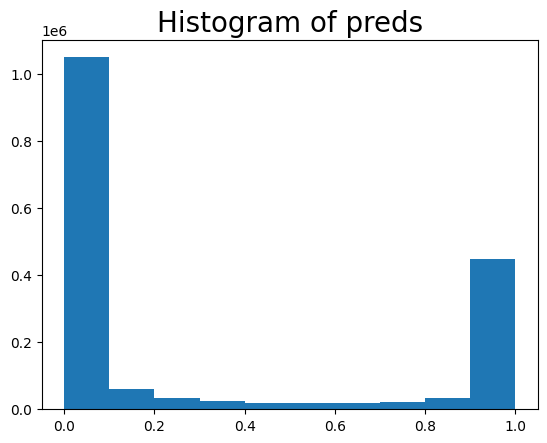

In [40]:
import matplotlib.pyplot as plt
plt.hist(sub['pred'], bins=10)
plt.title('Histogram of preds',size=20)
plt.show()